# paper: FRB 220319aaeb (SNR42, nearby)|

In [2]:
# input variables 
candidate = '220319aaeb'
dm_heimdall = 111
width_heimdall = 1 
snr_heimdall = 41.7

datestring = '2022_3_18_4_44_53'
beam = 172
corr = 'corr09'
fil_file = '/home/ubuntu/vikram/scratch/' + candidate + '.fil'
mask_chans=[] 

voltage = True
dedisperse = False
nfreq = 4 
fil_file_dedispersed = '/home/ubuntu/gechen/software/burstfit/fil_files_dedispersed/%s_%d_%s.txt'%(candidate, nfreq, str(voltage))



In [9]:
from burstfit.fit import BurstFit
from burstfit.data import BurstData
from burstfit.model import Model, SgramModel
from burstfit.utils.plotter import plot_me
from burstfit.utils.functions import pulse_fn, sgram_fn_vec, sgram_fn, gauss, gauss_norm, model_free_4, model_free_normalized_4, power_law # pulse_fn_vec  
from burstfit.utils.plotter import plot_fit_results, plot_2d_fit 
from burstfit.io import BurstIO
import logging
import numpy as np
import math
import matplotlib.pyplot as plt
# use Liam's function to read in filterbank files 
import sys
sys.path.insert(1, '/home/ubuntu/gechen/software')
import filplot_funcs_gc as ff

%matplotlib inline 


def prepare_bd(candidate, dm_heimdall, width_heimdall, snr_heimdall, mask_chans=[], 
               datestring=None, beam=None, corr=None, fil_file=None, voltage = False):
    if voltage: 
        fil_file = fil_file
    else: 
        fil_file ='/data/dsa110/T1/'+corr + '/' + datestring + '/fil_'+candidate+'/'+candidate+'_'+str(beam)+'.fil'
    
    logging_format = "%(asctime)s - %(funcName)s -%(name)s - %(levelname)s - %(message)s"
    logging.basicConfig(
        level=logging.INFO,
        format=logging_format,
    )
    
    bd = BurstData(
    fp=fil_file,
    dm=dm_heimdall ,
    tcand=0.5, # pulse starting time in s.
    width=width_heimdall,  
    snr=snr_heimdall
    )

    bd.prepare_data(mask_chans = mask_chans)
    print("using filterbank ", fil_file)
    
    return bd, fil_file 


def Bin_profile(data_t, bin_size):

    data_t_binned = np.array([])
    
    if bin_size == 1:
        data_t_binned = data_t
    elif bin_size > 1: 
        for i in range(0, len(data_t), bin_size):
            bin_value = np.sum(data_t[i : i + bin_size])
            data_t_binned = np.append(data_t_binned, bin_value)
    else: 
        print("bin_size is negative.")
    
    return data_t_binned, bin_size 



def prepare_burst_data(filterbank, fil_file_dedispersed, candidate, bd_heimdall, bd, t_chop_center_s = 0.5, 
                       voltage = True, t_chop_width = 50, dedisperse=False, nfreq = 4):
    """
    de-disperse data (or read from file) and chop near the burst time
    """
    # save the de-dispersed data to file (de-dispersion takes long time)
    if dedisperse:
        data = ff.proc_cand_fil(filterbank, bd.dm, bd.width, nfreq_plot=nfreq, ndm=64)[0]
        np.save(fil_file_dedispersed, data, allow_pickle=False)
    else: 
        data = np.load(fil_file_dedispersed + ".npy") 
    
    # heimdall burst starts at 500 ms, voltage removed edge channels so burst dedispersed to a later time
    if voltage:
        t_chop_center_s = 0.5 + 1e3 * (4.15 * bd.dm * (1 / bd.fch1 ** 2 - 1 / bd_heimdall.fch1 ** 2)) 
        bd.tcand = t_chop_center_s
    
    i_low = int(t_chop_center_s / bd.tsamp - t_chop_width * bd.width)
    i_high = int(t_chop_center_s / bd.tsamp + t_chop_width * bd.width)
    
    t_burst = [i * bd.tsamp * 1e3 for i in range(i_low, i_high)]
    data_burst = data[:, i_low: i_high] 
    
    bin_size = int(bd_heimdall.tsamp / bd.tsamp) 
    data_t_binned, bin_size = Bin_profile(data_burst.mean(0), bin_size) # bin profile to compare plots 

    fig1, ax1 = plt.subplots(1, 2, figsize=(12, 5)) 
    ax1[0].plot(t_burst[::bin_size], data_t_binned)
    ax1[0].set_xlabel('Time (ms) (binned %d to match Heimdall resolution)'%bin_size)
    ax1[1].plot(data_burst.mean(1))
    ax1[1].set_xlabel('Binned channel')
    ax1[1].set_title('bin freq channel #%d'%nfreq)
    plt.tight_layout()
    
    
    return data_burst # unbinned 2d 



def fit_paper_curvefit(data_2d, pnames, pulse_Model, profile_bounds, 
                       snames, spectra_Model, nfreq = 4, 
                       fix_ncomp=False, ncomp=1, plot=True):
    ncomp = ncomp
    pnames = pnames 
    pulseModel = Model(pulse_Model, param_names=pnames)
    spectraModel = Model(spectra_Model, param_names=snames)
    sgram_mask = np.full(np.shape(data_2d), False)
    sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)
    
    bf = BurstFit(
    sgram_model=sgramModel,
    sgram=data_2d, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False,
    #comp_num = 1,
    )
    
    bf.validate()
    bf.precalc()
    #bf.initial_profilefit(bounds = profile_bounds, plot = plot)
    #bf.initial_spectrafit(plot = plot)
    #bf.fitcycle(plot=plot, profile_bounds = profile_bounds) # fit for one component.
    bf.fitall(plot=plot, fix_ncomp = fix_ncomp, ncomp = ncomp, profile_bounds = profile_bounds) # fit all componnts 
    print('{bf}.calc_redchisq()=', bf.calc_redchisq())


    # plot_fit_results(bf_S1T2_c1.sgram, bf_S1T2_c1.sgram_model.evaluate, bf_S1T2_c1.sgram_params['all'][1]['popt'], 
    #                  bf_S1T2_c1.tsamp, bf_S1T2_c1.fch1, bf_S1T2_c1.foff, show=True, save=True, outname=save_name+'2d_fit_res_curvfit', outdir=save_dir)
    #dm_fit, dm_fit_err = bf_S1T2_c1.sgram_params['all'][1]['popt'][-1], bf_S1T2_c1.sgram_params['all'][1]['perr'][-1]

    return bf 


def fit_paper_mcmc_bic(bf, mcmc=True, nwalkers = 60, nsteps = 5000, n_param_overlap = 0):
    mcmc_kwargs = {'nwalkers':nwalkers, 'nsteps':nsteps,
               'skip':500, 'ncores':4, 
               'start_pos_dev':0.01,
               'prior_range':0.8, 
               'save_results':True,
               'outname':'test_file'}

    if mcmc:
        bf.run_mcmc(plot=True, **mcmc_kwargs)
    
    n_model_param = bf.comp_num * len(bf.param_names) - n_param_overlap 
    n_data = bf.nt * bf.nf 
    model_param = []
    for i in range(1, bf.comp_num + 1):
        model_param += bf.sgram_params['all'][i]['popt'] 

    lnL = bf.mcmc.lnlk(model_param)
    bf.BIC(lnL, n_model_param, n_data)
    print('{bf}.bic = ', bf.bic) 
    
    return 0


def select_model(bf_name_list):
    bic_list = []
    for name in bf_name_list:
        bf = globals()[name]
        bic_list = np.append(bic_list, bf.bic)
        
    return [x for _,x in sorted(zip(bic_list, bf_name_list))], bic_list


def autocorrelation():
    pass


2022-06-02 22:08:42,528 - prepare_data -burstfit.data - INFO - Preparing data for burst fitting.
2022-06-02 22:08:42,548 - crop_dedispersed_data -burstfit.data - INFO - Cropping data with time_window: 0.2s.
2022-06-02 22:08:42,550 - normalise_data -burstfit.data - INFO - Normalising data using off pulse mean and std.
2022-06-02 22:08:42,553 - normalise_data -burstfit.data - INFO - Off pulse mean and std are: (masked, masked)


using filterbank  /data/dsa110/T1/corr09/2022_3_18_4_44_53/fil_220319aaeb/220319aaeb_172.fil


2022-06-02 22:08:42,562 - prepare_data -burstfit.data - INFO - Preparing data for burst fitting.
2022-06-02 22:08:43,159 - crop_dedispersed_data -burstfit.data - INFO - Cropping data with time_window: 0.2s.
2022-06-02 22:08:43,163 - normalise_data -burstfit.data - INFO - Normalising data using off pulse mean and std.
2022-06-02 22:08:43,165 - normalise_data -burstfit.data - INFO - Off pulse mean and std are: (masked, masked)


using filterbank  /home/ubuntu/vikram/scratch/220319aaeb.fil
/home/ubuntu/vikram/scratch/220319aaeb.fil 3.2768e-05 0.000262144


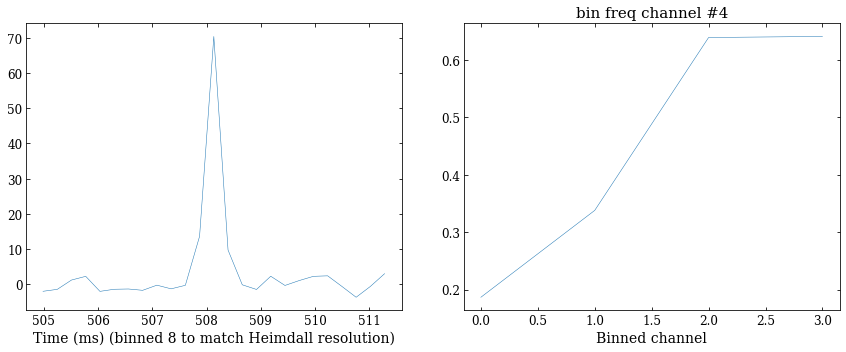

In [14]:
bd_heimdall, fil_file_heimdall  = prepare_bd(candidate, dm_heimdall, width_heimdall, snr_heimdall, 
                           datestring=datestring, beam=beam, corr=corr, 
                           fil_file=fil_file, voltage=False)

bd, fil_file  = prepare_bd(candidate, dm_heimdall, width_heimdall, snr_heimdall, 
                           datestring=datestring, beam=beam, corr=corr, 
                           fil_file=fil_file, voltage=True)


print(fil_file, bd.tsamp, bd_heimdall.tsamp)
data_burst = prepare_burst_data(fil_file, candidate, bd_heimdall, bd, voltage = voltage,
                                t_chop_center_s=0.5, t_chop_width = 100, 
                               dedisperse=dedisperse, nfreq = nfreq)

## S1: Spectrum--  4 channels, normalized
## T1: Time profile-- Gaussian 
## T2: Time profile-- Gaussian + scattering
## cx: x-components in time profile 

self.function_input_names:  ['S', 'mu', 'sigma']
self.function_input_names:  ['c0', 'c1', 'c2']


2022-05-31 21:26:03,908 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-31 21:26:03,911 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-31 21:26:03,916 - tests -root - INFO - P values: T-test (0.18051), Kruskal (0.14148), KS (0.28267), F-test (0.15210)
2022-05-31 21:26:03,918 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2022-05-31 21:26:03,921 - tests -root - INFO - P values: T-test (0.35209), Kruskal (0.24800), KS (0.28267), F-test (0.08019)
2022-05-31 21:26:03,923 - run_tests -burstfit.fit - INFO - On pulse residual is similar to left off pulse region.
2022-05-31 21:26:03,925 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2022-05-31 21:26:03,929 - tests -root - INFO - P values: T-test (0.79841), Kruskal (0.59951), KS (0.66014), F-test (0.34593)
2022-05-31 21:26:03,931 - run_tests -burstfit.fit - INFO - On pulse residual is similar to right off pulse region.
2022-0

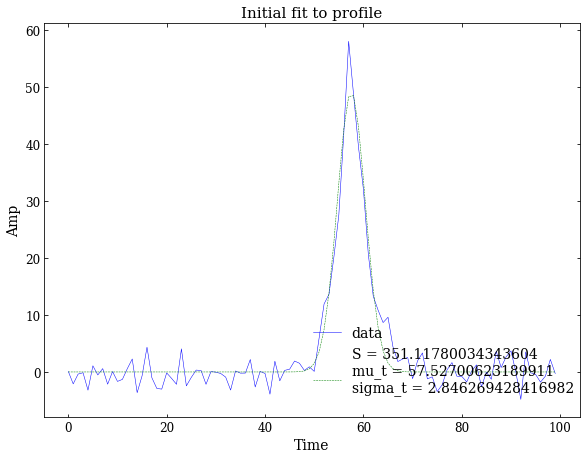

2022-05-31 21:26:04,098 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-31 21:26:04,100 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1


<function model_free_normalized_4 at 0x7f36b08a4ea0>
[0.09705494 0.26526412 0.44478154 0.48285386]


2022-05-31 21:26:04,107 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-31 21:26:04,109 - initial_spectrafit -burstfit.fit - INFO - c0: 0.09705493599176407 +- 0.0
2022-05-31 21:26:04,112 - initial_spectrafit -burstfit.fit - INFO - c1: 0.2652641236782074 +- 0.0
2022-05-31 21:26:04,115 - initial_spectrafit -burstfit.fit - INFO - c2: 0.4447815418243408 +- 0.0


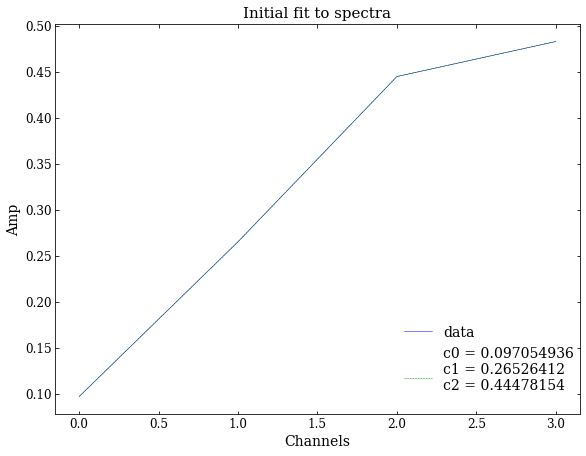

2022-05-31 21:26:04,269 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2022-05-31 21:26:04,272 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [0.097054936, 0.26526412, 0.44478154, 351.11780034343604, 57.52700623189911, 2.846269428416982, 111]
2022-05-31 21:26:04,362 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-31 21:26:04,364 - sgram_fit -burstfit.fit - INFO - c0: 0.09247108910051087 +- 0.012467979802253134
2022-05-31 21:26:04,367 - sgram_fit -burstfit.fit - INFO - c1: 0.2726246998631309 +- 0.01026277144587941
2022-05-31 21:26:04,369 - sgram_fit -burstfit.fit - INFO - c2: 0.4362088114603945 +- 0.010201264217281444
2022-05-31 21:26:04,371 - sgram_fit -burstfit.fit - INFO - S: 282.81339367640777 +- 16.791748234601382
2022-05-31 21:26:04,373 - sgram_fit -burstfit.fit - INFO - mu_t: 58.05016647489579 +- 0.24309123673288055
2022-05-31 21:26:04,375 - sgram_fit -burstfit.fit - INFO - sigma_t: 3.1207590252180566 +- 0.0

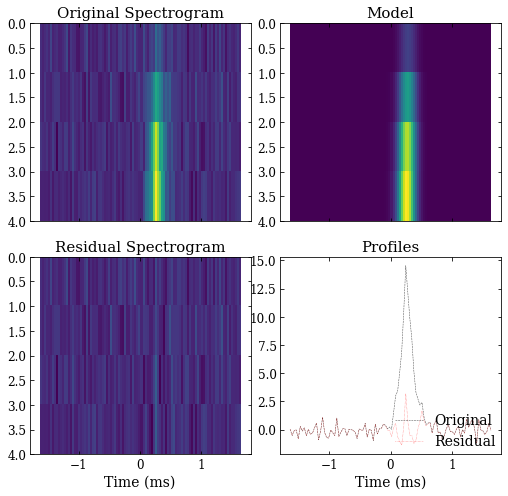

2022-05-31 21:26:04,724 - model -burstfit.fit - INFO - Making model.
2022-05-31 21:26:04,727 - model -burstfit.fit - INFO - Found 1 components.
2022-05-31 21:26:04,730 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-31 21:26:04,732 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-31 21:26:04,735 - model -burstfit.fit - INFO - Making model.
2022-05-31 21:26:04,737 - model -burstfit.fit - INFO - Found 1 components.
2022-05-31 21:26:04,740 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.3672337201506028
2022-05-31 21:26:04,741 - fitall -burstfit.fit - INFO - Fixed component exceeded. Terminated individual component fitting.
2022-05-31 21:26:04,743 - fitall -burstfit.fit - INFO - Final number of components = 1. Terminating fitting.
2022-05-31 21:26:04,745 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to

{bf}.calc_redchisq()= 1.3672337201506028


In [5]:
bf_S1T1_c1 = fit_paper_curvefit(data_burst, ['S', 'mu_t', 'sigma_t'], gauss, 
          [(0, 50, 0),(np.inf, 60, 5*bd.width)], 
          ['c0', 'c1', 'c2'], model_free_normalized_4, fix_ncomp=True, ncomp=1, plot=True)

2022-05-31 21:26:04,766 - set_initial_pos -root - INFO - Setting initial positions for MCMC.
2022-05-31 21:26:04,768 - set_initial_pos -burstfit.mcmc - INFO - Initial guess for MCMC is: [9.24710891e-02 2.72624700e-01 4.36208811e-01 2.82813394e+02
 5.80501665e+01 3.12075903e+00 1.10598965e+02]
2022-05-31 21:26:04,770 - set_priors -burstfit.mcmc - INFO - Setting priors for MCMC.
2022-05-31 21:26:04,772 - set_priors -burstfit.mcmc - INFO - Found sigma_t in param_names. Setting its min value of prior to 0.
2022-05-31 21:26:04,774 - set_priors -burstfit.mcmc - INFO - Found S and sigma_t in param_names. Setting its max value of prior to 500*max(ts)*max_sigma_t_prior. Setting its min value of prior to 0.
2022-05-31 21:26:04,781 - run_mcmc -burstfit.mcmc - INFO - Running MCMC with the following parameters: nwalkers=60, nsteps=5000, start_pos_dev=0.01, ncores=4, skip=500
2022-05-31 21:26:04,783 - run_mcmc -burstfit.mcmc - INFO - Priors used in MCMC are:
2022-05-31 21:26:04,785 - run_mcmc -burst

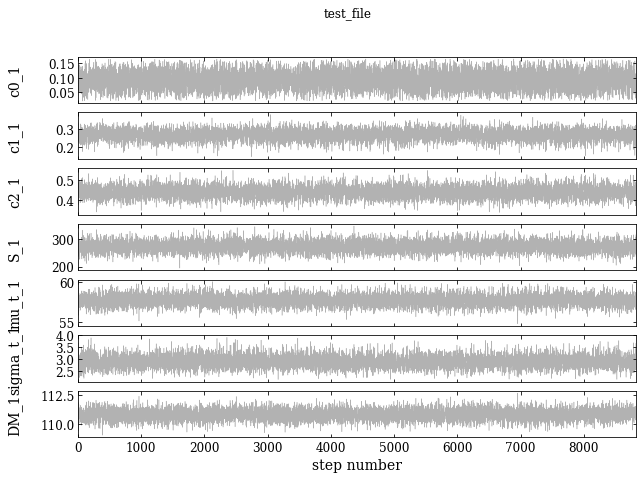

<Figure size 432x288 with 0 Axes>

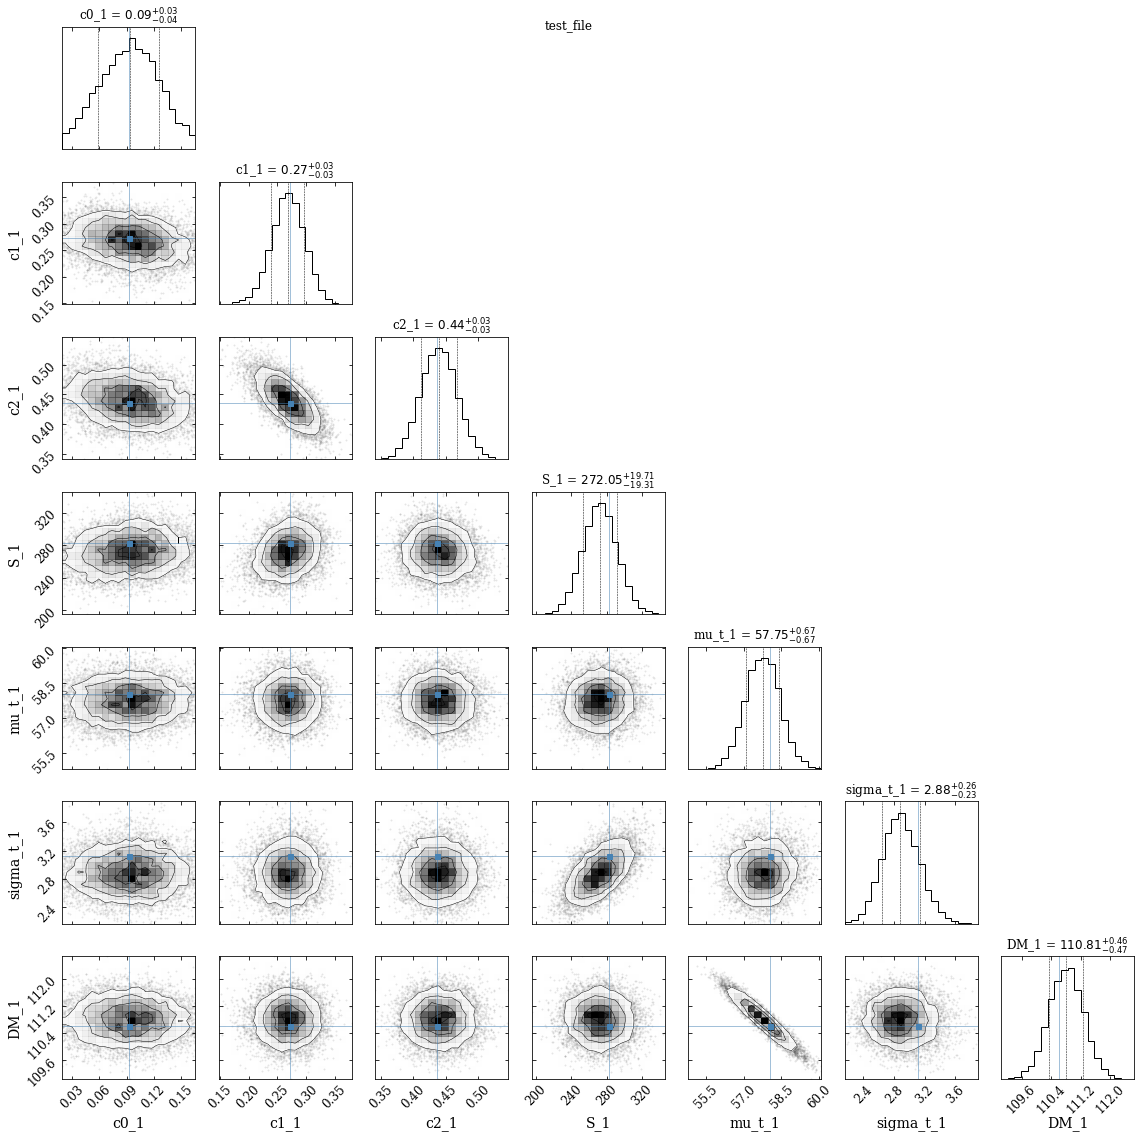

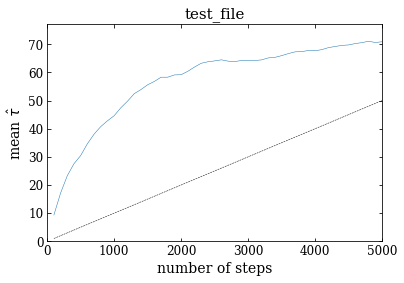

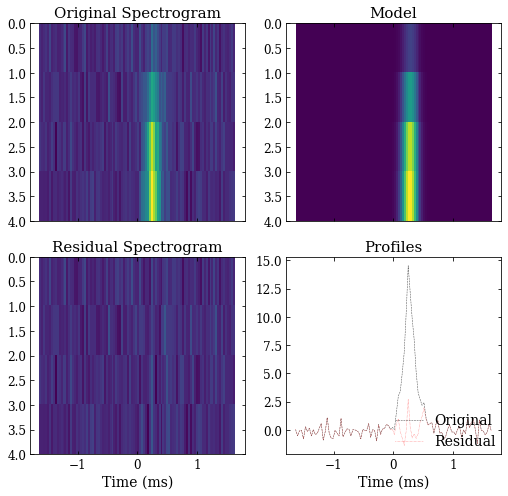

{bf}.bic =  91.51716141450237


0

In [6]:
fit_paper_mcmc_bic(bf_S1T1_c1, mcmc=True)

self.function_input_names:  ['S', 'mu', 'sigma']
self.function_input_names:  ['c0', 'c1', 'c2']


2022-05-31 21:29:24,567 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-31 21:29:24,570 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-31 21:29:24,575 - tests -root - INFO - P values: T-test (0.18051), Kruskal (0.14148), KS (0.28267), F-test (0.15210)
2022-05-31 21:29:24,578 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2022-05-31 21:29:24,582 - tests -root - INFO - P values: T-test (0.35209), Kruskal (0.24800), KS (0.28267), F-test (0.08019)
2022-05-31 21:29:24,585 - run_tests -burstfit.fit - INFO - On pulse residual is similar to left off pulse region.
2022-05-31 21:29:24,586 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2022-05-31 21:29:24,590 - tests -root - INFO - P values: T-test (0.79841), Kruskal (0.59951), KS (0.66014), F-test (0.34593)
2022-05-31 21:29:24,592 - run_tests -burstfit.fit - INFO - On pulse residual is similar to right off pulse region.
2022-0

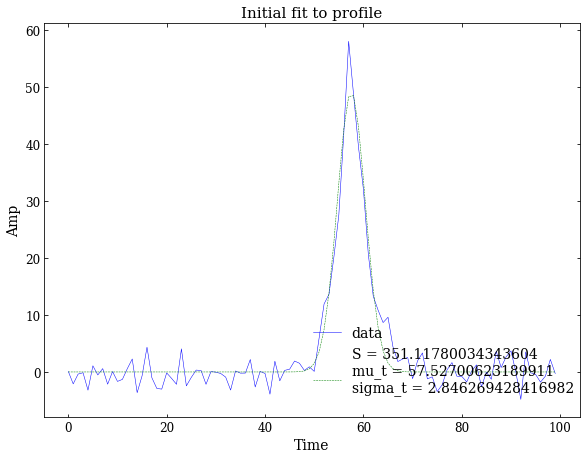

2022-05-31 21:29:24,792 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-31 21:29:24,795 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1


<function model_free_normalized_4 at 0x7f36b08a4ea0>
[0.09705494 0.26526412 0.44478154 0.48285386]


2022-05-31 21:29:24,801 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-31 21:29:24,802 - initial_spectrafit -burstfit.fit - INFO - c0: 0.09705493599176407 +- 0.0
2022-05-31 21:29:24,804 - initial_spectrafit -burstfit.fit - INFO - c1: 0.2652641236782074 +- 0.0
2022-05-31 21:29:24,806 - initial_spectrafit -burstfit.fit - INFO - c2: 0.4447815418243408 +- 0.0


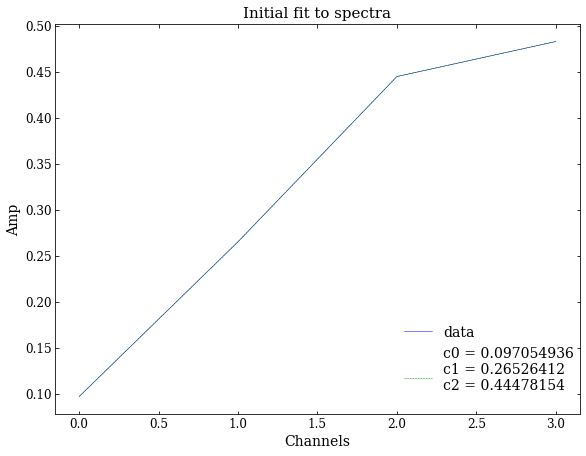

2022-05-31 21:29:24,988 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2022-05-31 21:29:24,990 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [0.097054936, 0.26526412, 0.44478154, 351.11780034343604, 57.52700623189911, 2.846269428416982, 111]
2022-05-31 21:29:25,093 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-31 21:29:25,096 - sgram_fit -burstfit.fit - INFO - c0: 0.09247108910051087 +- 0.012467979802253134
2022-05-31 21:29:25,098 - sgram_fit -burstfit.fit - INFO - c1: 0.2726246998631309 +- 0.01026277144587941
2022-05-31 21:29:25,101 - sgram_fit -burstfit.fit - INFO - c2: 0.4362088114603945 +- 0.010201264217281444
2022-05-31 21:29:25,103 - sgram_fit -burstfit.fit - INFO - S: 282.81339367640777 +- 16.791748234601382
2022-05-31 21:29:25,105 - sgram_fit -burstfit.fit - INFO - mu_t: 58.05016647489579 +- 0.24309123673288055
2022-05-31 21:29:25,107 - sgram_fit -burstfit.fit - INFO - sigma_t: 3.1207590252180566 +- 0.0

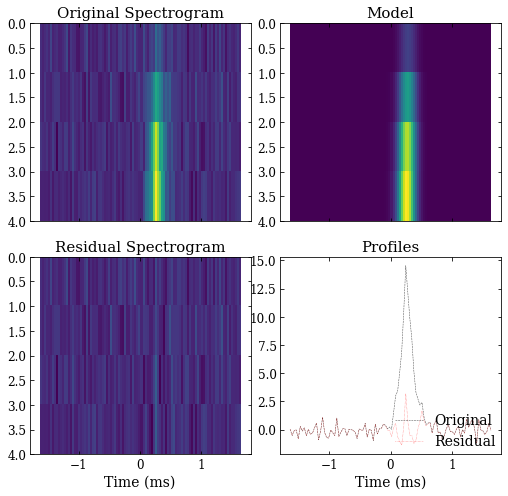

2022-05-31 21:29:25,503 - model -burstfit.fit - INFO - Making model.
2022-05-31 21:29:25,505 - model -burstfit.fit - INFO - Found 1 components.
2022-05-31 21:29:25,509 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-31 21:29:25,512 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-31 21:29:25,514 - model -burstfit.fit - INFO - Making model.
2022-05-31 21:29:25,515 - model -burstfit.fit - INFO - Found 1 components.
2022-05-31 21:29:25,518 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.3672337201506028
2022-05-31 21:29:25,520 - fitall -burstfit.fit - WARNING - Input profile bounds detected. Using them for component 2
2022-05-31 21:29:25,521 - fitcycle -burstfit.fit - INFO - Fitting component 2.
2022-05-31 21:29:25,523 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 2
2022-05-31 21:29:25,534 - initial_profile

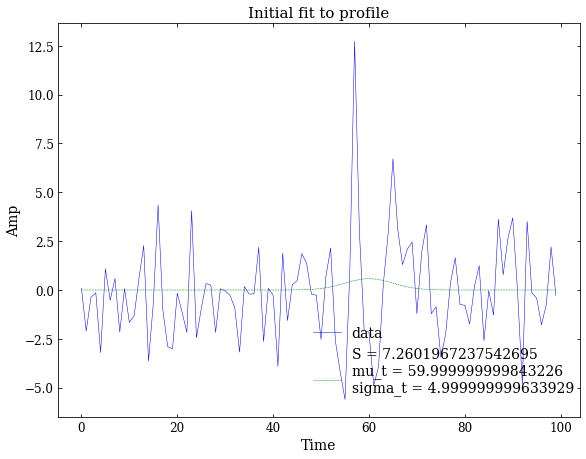

2022-05-31 21:29:25,690 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-31 21:29:25,694 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 2


<function model_free_normalized_4 at 0x7f36b08a4ea0>
[0.3407998241327819 -0.8619967971616367 0.15233054083154046
 3.0785326885274102]


2022-05-31 21:29:25,701 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-31 21:29:25,703 - initial_spectrafit -burstfit.fit - INFO - c0: 0.3407998241327819 +- 0.0
2022-05-31 21:29:25,706 - initial_spectrafit -burstfit.fit - INFO - c1: -0.8619967971616367 +- 0.0
2022-05-31 21:29:25,708 - initial_spectrafit -burstfit.fit - INFO - c2: 0.15233054083154046 +- 0.0


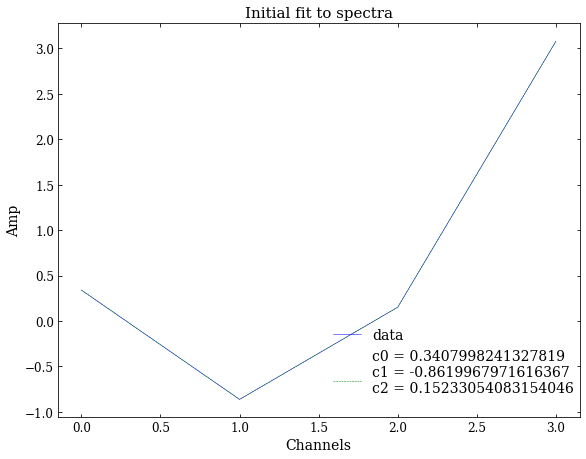

2022-05-31 21:29:25,860 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 2
2022-05-31 21:29:25,863 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [0.3407998241327819, -0.8619967971616367, 0.15233054083154046, 7.2601967237542695, 59.999999999843226, 4.999999999633929, 111]
2022-05-31 21:29:25,893 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-31 21:29:25,896 - sgram_fit -burstfit.fit - INFO - c0: 0.6299488265479406 +- 7.543272746234074
2022-05-31 21:29:25,899 - sgram_fit -burstfit.fit - INFO - c1: -0.5419770227288403 +- 6.646234843655469
2022-05-31 21:29:25,901 - sgram_fit -burstfit.fit - INFO - c2: 0.4680842837912329 +- 6.0921904443734824
2022-05-31 21:29:25,903 - sgram_fit -burstfit.fit - INFO - S: -0.6147613469694375 +- 1.40701778272429
2022-05-31 21:29:25,904 - sgram_fit -burstfit.fit - INFO - mu_t: 59.21983643236025 +- 68.64269591165161
2022-05-31 21:29:25,906 - sgram_fit -burstfit.fit - INFO - sigma_t: 5.2950846

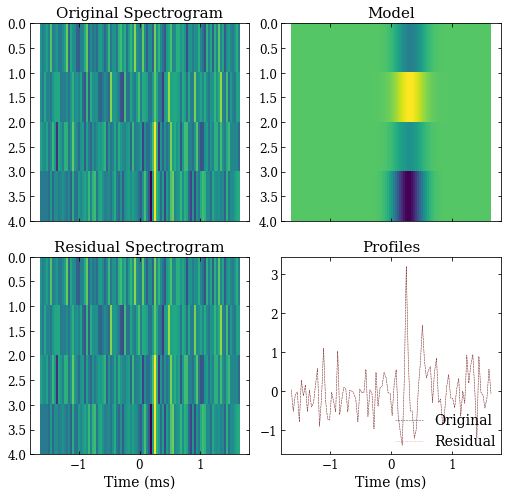

2022-05-31 21:29:26,237 - model -burstfit.fit - INFO - Making model.
2022-05-31 21:29:26,240 - model -burstfit.fit - INFO - Found 2 components.
2022-05-31 21:29:26,244 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-31 21:29:26,247 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-31 21:29:26,250 - model -burstfit.fit - INFO - Making model.
2022-05-31 21:29:26,252 - model -burstfit.fit - INFO - Found 2 components.
2022-05-31 21:29:26,256 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.531866091781872
2022-05-31 21:29:26,259 - fitall -burstfit.fit - INFO - Fixed component exceeded. Terminated individual component fitting.
2022-05-31 21:29:26,261 - fitall -burstfit.fit - INFO - Final number of components 2 > 1. Fitting all components together.
2022-05-31 21:29:26,262 - fit_all_components -burstfit.fit - INFO - Fitting 2 components together.
2022-0

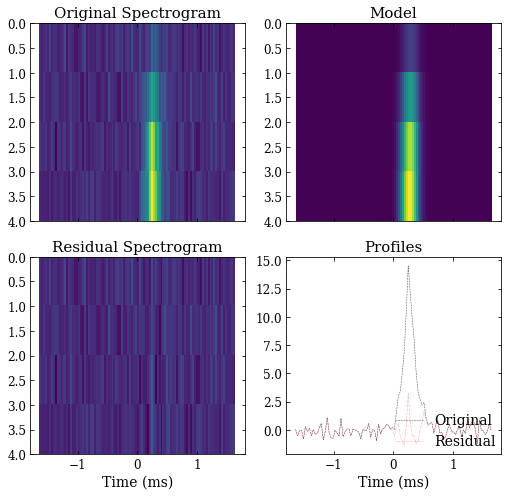

2022-05-31 21:29:26,933 - model -burstfit.fit - INFO - Making model.
2022-05-31 21:29:26,936 - model -burstfit.fit - INFO - Found 2 components.
2022-05-31 21:29:26,939 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-31 21:29:26,942 - get_off_pulse_region -burstfit.fit - INFO - Using sgram all-component-fit parameters.
2022-05-31 21:29:26,944 - model -burstfit.fit - INFO - Making model.
2022-05-31 21:29:26,946 - model -burstfit.fit - INFO - Found 2 components.
2022-05-31 21:29:26,949 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.4252859201378651
2022-05-31 21:29:26,950 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-31 21:29:26,952 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-31 21:29:26,956 - tests -root - INFO - P values: T-test (0.18051), Kruskal (0.14148), KS (0.28267), F-test (0.15210)
2022-05-31 21:2

{bf}.calc_redchisq()= 1.4252859201378651


In [7]:
bf_S1T1_c2 = fit_paper_curvefit(data_burst, ['S', 'mu_t', 'sigma_t'], gauss, 
          [(0, 50, 0),(np.inf, 60, 5*bd.width)], 
          ['c0', 'c1', 'c2'], model_free_normalized_4, fix_ncomp = True, ncomp=2, plot=True)

2022-05-31 21:29:26,996 - set_initial_pos -root - INFO - Setting initial positions for MCMC.
2022-05-31 21:29:26,998 - set_initial_pos -burstfit.mcmc - INFO - Initial guess for MCMC is: [ 9.22552309e-02  2.72060088e-01  4.36263500e-01  2.82576986e+02
  5.80491862e+01  3.12405298e+00  1.10600968e+02  5.03319523e-01
 -8.16004548e-01  6.03190294e-01 -8.54345227e-01  5.37674739e+01
  2.60644440e+00  1.08684948e+02]
2022-05-31 21:29:27,001 - set_priors -burstfit.mcmc - INFO - Setting priors for MCMC.
2022-05-31 21:29:27,004 - set_priors -burstfit.mcmc - INFO - Found sigma_t in param_names. Setting its min value of prior to 0.
2022-05-31 21:29:27,006 - set_priors -burstfit.mcmc - INFO - Found S and sigma_t in param_names. Setting its max value of prior to 500*max(ts)*max_sigma_t_prior. Setting its min value of prior to 0.
2022-05-31 21:29:27,015 - run_mcmc -burstfit.mcmc - INFO - Running MCMC with the following parameters: nwalkers=60, nsteps=5000, start_pos_dev=0.01, ncores=4, skip=500
2022

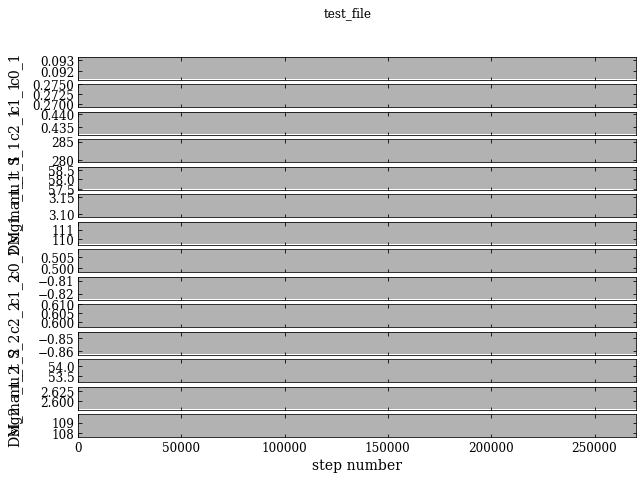

<Figure size 432x288 with 0 Axes>

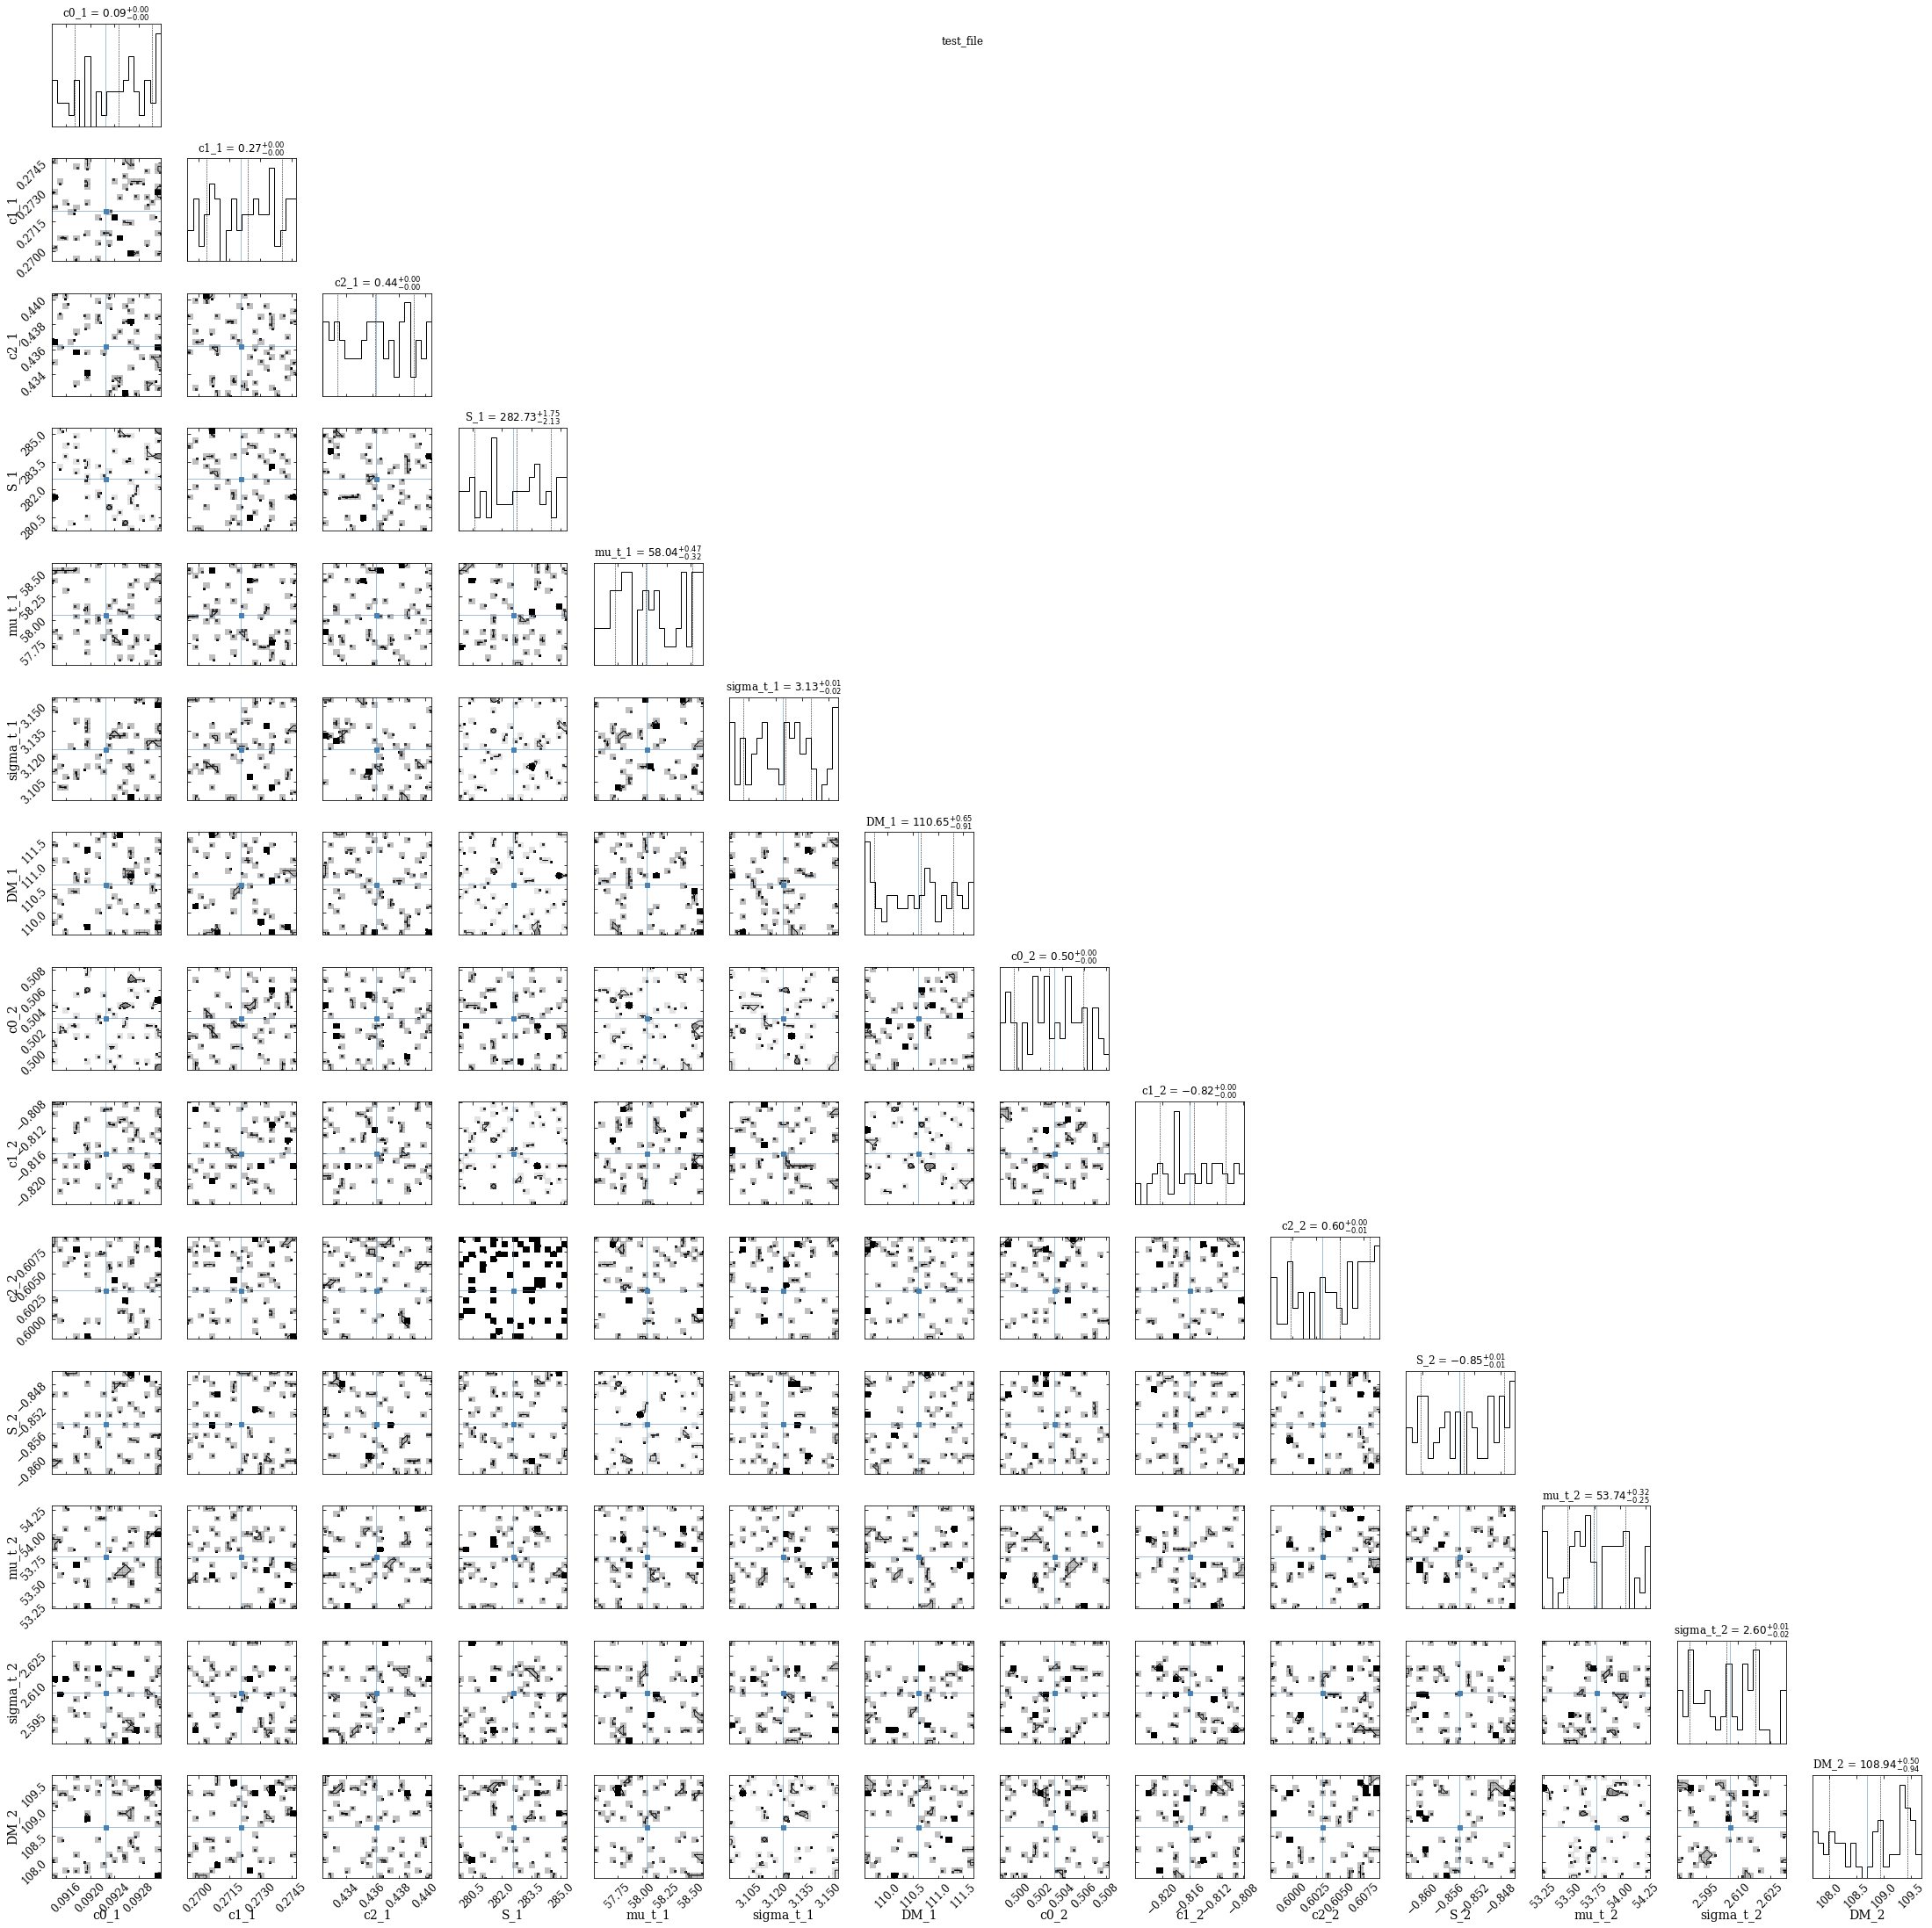

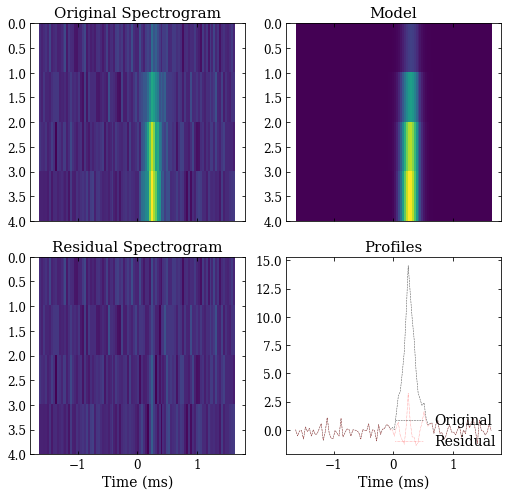

{bf}.bic =  133.2893091125506


0

In [8]:
fit_paper_mcmc_bic(bf_S1T1_c2, mcmc=True)

self.function_input_names:  ['S', 'mu', 'sigma', 'tau']
self.function_input_names:  ['c0', 'c1', 'c2']


2022-05-31 21:33:44,863 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-31 21:33:44,866 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-31 21:33:44,870 - tests -root - INFO - P values: T-test (0.18051), Kruskal (0.14148), KS (0.28267), F-test (0.15210)
2022-05-31 21:33:44,873 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2022-05-31 21:33:44,877 - tests -root - INFO - P values: T-test (0.35209), Kruskal (0.24800), KS (0.28267), F-test (0.08019)
2022-05-31 21:33:44,879 - run_tests -burstfit.fit - INFO - On pulse residual is similar to left off pulse region.
2022-05-31 21:33:44,880 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2022-05-31 21:33:44,884 - tests -root - INFO - P values: T-test (0.79841), Kruskal (0.59951), KS (0.66014), F-test (0.34593)
2022-05-31 21:33:44,885 - run_tests -burstfit.fit - INFO - On pulse residual is similar to right off pulse region.
2022-0

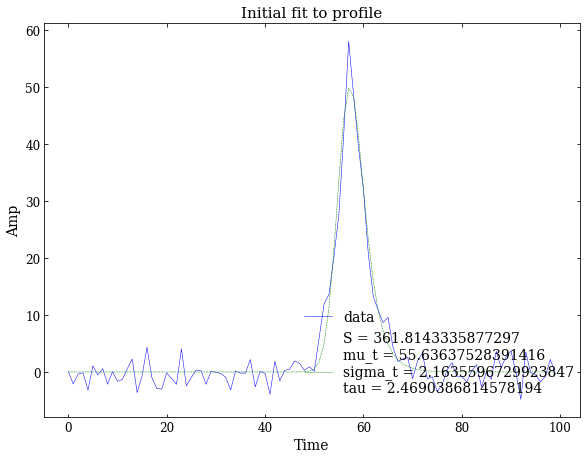

2022-05-31 21:33:45,064 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-31 21:33:45,067 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1


<function model_free_normalized_4 at 0x7f36b08a4ea0>
[0.08730642 0.26856065 0.43957722 0.49641785]


2022-05-31 21:33:45,073 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-31 21:33:45,075 - initial_spectrafit -burstfit.fit - INFO - c0: 0.0873064175248146 +- 0.0
2022-05-31 21:33:45,077 - initial_spectrafit -burstfit.fit - INFO - c1: 0.26856064796447754 +- 0.0
2022-05-31 21:33:45,078 - initial_spectrafit -burstfit.fit - INFO - c2: 0.43957722187042236 +- 0.0


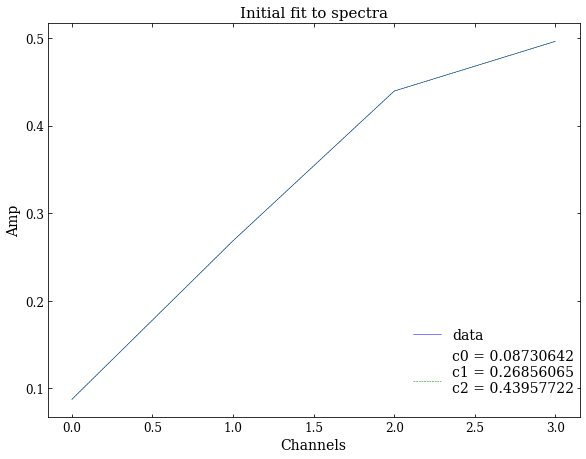

2022-05-31 21:33:45,219 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2022-05-31 21:33:45,223 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [0.08730642, 0.26856065, 0.43957722, 361.8143335877297, 55.63637528391416, 2.1635596729923847, 2.4690386814578194, 111]
2022-05-31 21:33:45,318 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-31 21:33:45,321 - sgram_fit -burstfit.fit - INFO - c0: 0.09799433104915144 +- 0.011696992870679747
2022-05-31 21:33:45,325 - sgram_fit -burstfit.fit - INFO - c1: 0.27769008918778687 +- 0.011111265868948337
2022-05-31 21:33:45,328 - sgram_fit -burstfit.fit - INFO - c2: 0.4344421329228058 +- 0.010229289730381914
2022-05-31 21:33:45,331 - sgram_fit -burstfit.fit - INFO - S: 304.6688811645201 +- 2.604007628547055
2022-05-31 21:33:45,333 - sgram_fit -burstfit.fit - INFO - mu_t: 55.75244136680567 +- 0.2110028697758056
2022-05-31 21:33:45,336 - sgram_fit -burstfit.fit - INFO - sigma_t: 2.29498

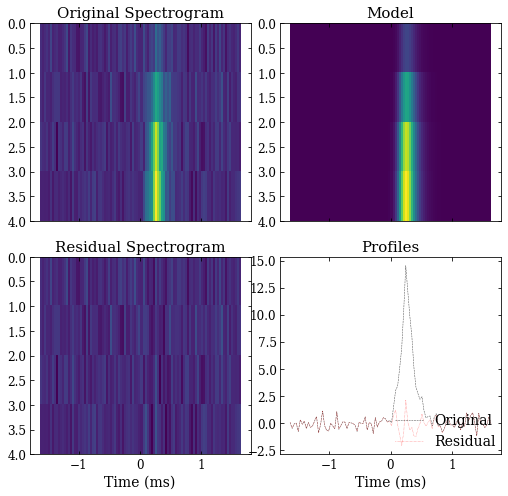

2022-05-31 21:33:45,762 - model -burstfit.fit - INFO - Making model.
2022-05-31 21:33:45,765 - model -burstfit.fit - INFO - Found 1 components.
2022-05-31 21:33:45,768 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-31 21:33:45,771 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-31 21:33:45,773 - model -burstfit.fit - INFO - Making model.
2022-05-31 21:33:45,774 - model -burstfit.fit - INFO - Found 1 components.
2022-05-31 21:33:45,777 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.3828998315918302
2022-05-31 21:33:45,779 - fitall -burstfit.fit - INFO - Fixed component exceeded. Terminated individual component fitting.
2022-05-31 21:33:45,781 - fitall -burstfit.fit - INFO - Final number of components = 1. Terminating fitting.
2022-05-31 21:33:45,783 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to

{bf}.calc_redchisq()= 1.3828998315918302


In [9]:
bf_S1T2_c1 = fit_paper_curvefit(data_burst, ['S', 'mu_t', 'sigma_t', 'tau'], pulse_fn, 
          [(0, 50, 0, 0),(np.inf, 60, 10*bd.width, np.inf)], 
          ['c0', 'c1', 'c2'], model_free_normalized_4, fix_ncomp = True, ncomp=1, plot=True)

2022-05-31 21:33:45,805 - set_initial_pos -root - INFO - Setting initial positions for MCMC.
2022-05-31 21:33:45,807 - set_initial_pos -burstfit.mcmc - INFO - Initial guess for MCMC is: [9.79943310e-02 2.77690089e-01 4.34442133e-01 3.04668881e+02
 5.57524414e+01 2.29498059e+00 2.62297000e+00 1.10744469e+02]
2022-05-31 21:33:45,810 - set_priors -burstfit.mcmc - INFO - Setting priors for MCMC.
2022-05-31 21:33:45,812 - set_priors -burstfit.mcmc - INFO - Found tau in param_names. Setting its min value of prior to 0.
2022-05-31 21:33:45,813 - set_priors -burstfit.mcmc - INFO - Found sigma_t in param_names. Setting its min value of prior to 0.
2022-05-31 21:33:45,815 - set_priors -burstfit.mcmc - INFO - Found sigma_t and tau in param_names. Setting its max value of prior to 2*(max_tau_prior(4.72134599987634) + max_sigma_t_prior(4.13096506487006))
2022-05-31 21:33:45,817 - set_priors -burstfit.mcmc - INFO - Found S and sigma_t in param_names. Setting its max value of prior to 500*max(ts)*max

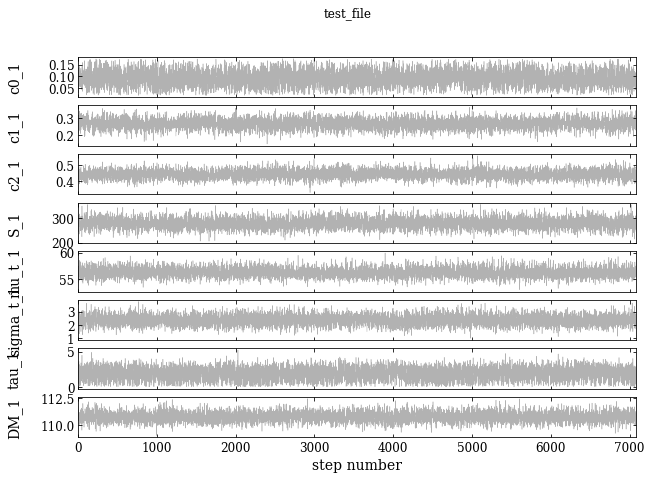

<Figure size 432x288 with 0 Axes>

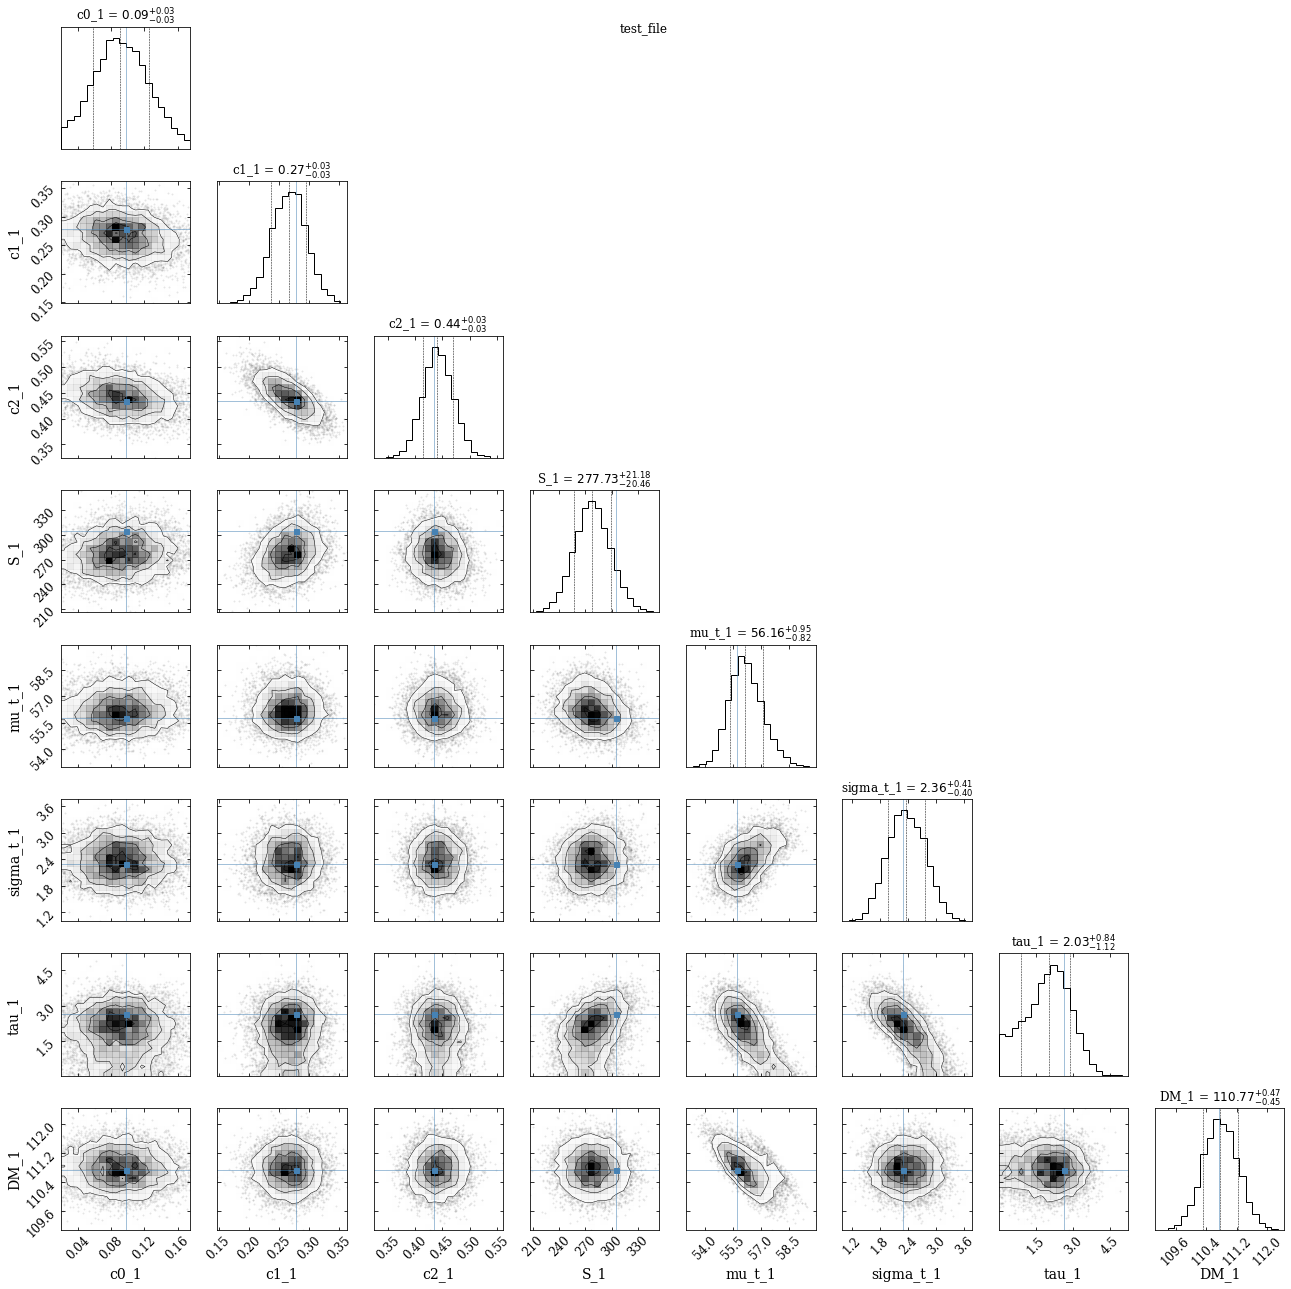

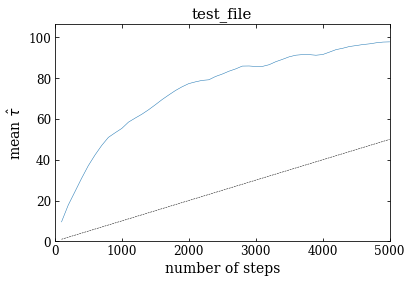

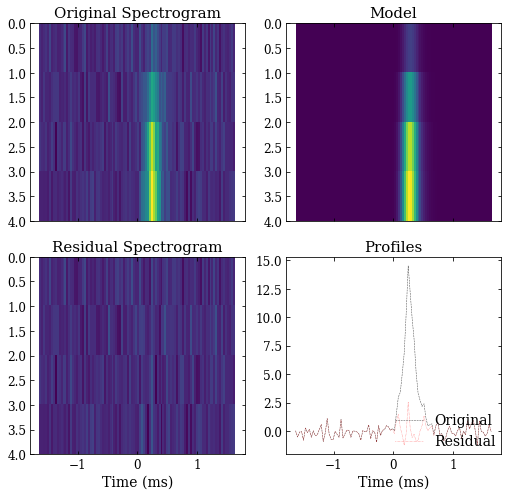

{bf}.bic =  95.59347084829446


0

In [10]:
fit_paper_mcmc_bic(bf_S1T2_c1, mcmc=True)

self.function_input_names:  ['S', 'mu', 'sigma', 'tau']
self.function_input_names:  ['c0', 'c1', 'c2']


2022-05-31 21:39:46,031 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-31 21:39:46,033 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-31 21:39:46,039 - tests -root - INFO - P values: T-test (0.18051), Kruskal (0.14148), KS (0.28267), F-test (0.15210)
2022-05-31 21:39:46,042 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2022-05-31 21:39:46,046 - tests -root - INFO - P values: T-test (0.35209), Kruskal (0.24800), KS (0.28267), F-test (0.08019)
2022-05-31 21:39:46,048 - run_tests -burstfit.fit - INFO - On pulse residual is similar to left off pulse region.
2022-05-31 21:39:46,050 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2022-05-31 21:39:46,054 - tests -root - INFO - P values: T-test (0.79841), Kruskal (0.59951), KS (0.66014), F-test (0.34593)
2022-05-31 21:39:46,056 - run_tests -burstfit.fit - INFO - On pulse residual is similar to right off pulse region.
2022-0

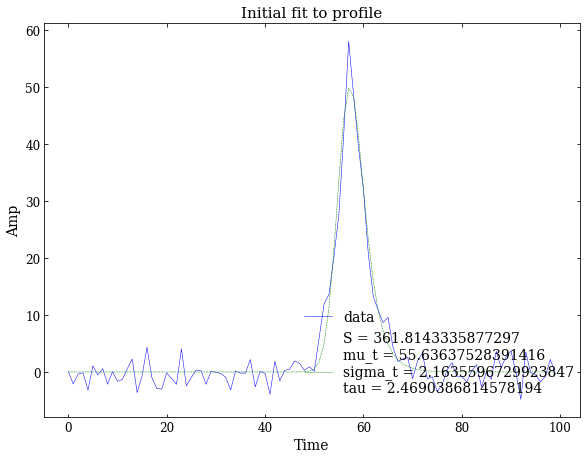

2022-05-31 21:39:46,284 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-31 21:39:46,288 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1


<function model_free_normalized_4 at 0x7f36b08a4ea0>
[0.08730642 0.26856065 0.43957722 0.49641785]


2022-05-31 21:39:46,294 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-31 21:39:46,296 - initial_spectrafit -burstfit.fit - INFO - c0: 0.0873064175248146 +- 0.0
2022-05-31 21:39:46,298 - initial_spectrafit -burstfit.fit - INFO - c1: 0.26856064796447754 +- 0.0
2022-05-31 21:39:46,300 - initial_spectrafit -burstfit.fit - INFO - c2: 0.43957722187042236 +- 0.0


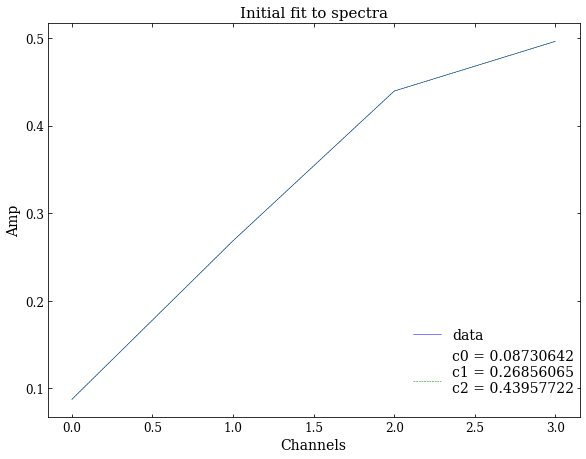

2022-05-31 21:39:46,475 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2022-05-31 21:39:46,477 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [0.08730642, 0.26856065, 0.43957722, 361.8143335877297, 55.63637528391416, 2.1635596729923847, 2.4690386814578194, 111]
2022-05-31 21:39:46,567 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-31 21:39:46,570 - sgram_fit -burstfit.fit - INFO - c0: 0.09799433104915144 +- 0.011696992870679747
2022-05-31 21:39:46,572 - sgram_fit -burstfit.fit - INFO - c1: 0.27769008918778687 +- 0.011111265868948337
2022-05-31 21:39:46,574 - sgram_fit -burstfit.fit - INFO - c2: 0.4344421329228058 +- 0.010229289730381914
2022-05-31 21:39:46,577 - sgram_fit -burstfit.fit - INFO - S: 304.6688811645201 +- 2.604007628547055
2022-05-31 21:39:46,579 - sgram_fit -burstfit.fit - INFO - mu_t: 55.75244136680567 +- 0.2110028697758056
2022-05-31 21:39:46,580 - sgram_fit -burstfit.fit - INFO - sigma_t: 2.29498

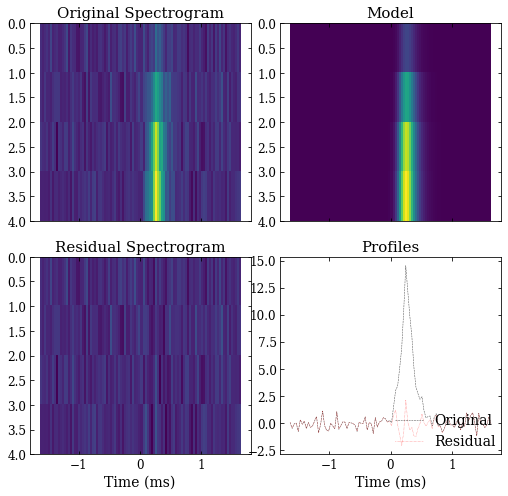

2022-05-31 21:39:47,006 - model -burstfit.fit - INFO - Making model.
2022-05-31 21:39:47,009 - model -burstfit.fit - INFO - Found 1 components.
2022-05-31 21:39:47,013 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-31 21:39:47,015 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-31 21:39:47,017 - model -burstfit.fit - INFO - Making model.
2022-05-31 21:39:47,019 - model -burstfit.fit - INFO - Found 1 components.
2022-05-31 21:39:47,022 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.3828998315918302
2022-05-31 21:39:47,024 - fitall -burstfit.fit - WARNING - Input profile bounds detected. Using them for component 2
2022-05-31 21:39:47,026 - fitcycle -burstfit.fit - INFO - Fitting component 2.
2022-05-31 21:39:47,028 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 2
2022-05-31 21:39:47,038 - initial_profile

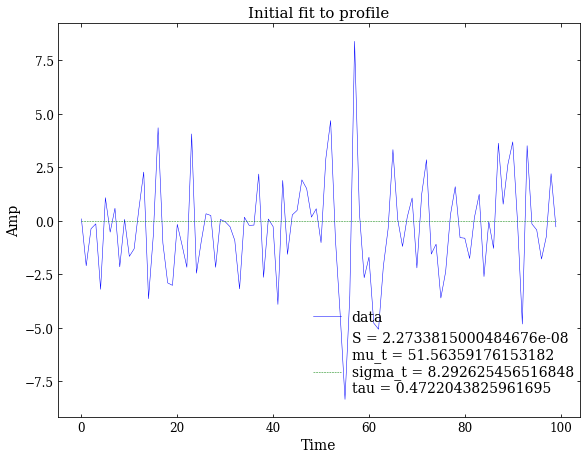

2022-05-31 21:39:47,194 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-31 21:39:47,196 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 2


<function model_free_normalized_4 at 0x7f36b08a4ea0>
[-0.9619920976351409 0.31603553866551093 1.3499121014372446
 -0.3699031825703704]


2022-05-31 21:39:47,201 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-31 21:39:47,202 - initial_spectrafit -burstfit.fit - INFO - c0: -0.9619920976351409 +- 0.0
2022-05-31 21:39:47,204 - initial_spectrafit -burstfit.fit - INFO - c1: 0.31603553866551093 +- 0.0
2022-05-31 21:39:47,206 - initial_spectrafit -burstfit.fit - INFO - c2: 1.3499121014372446 +- 0.0


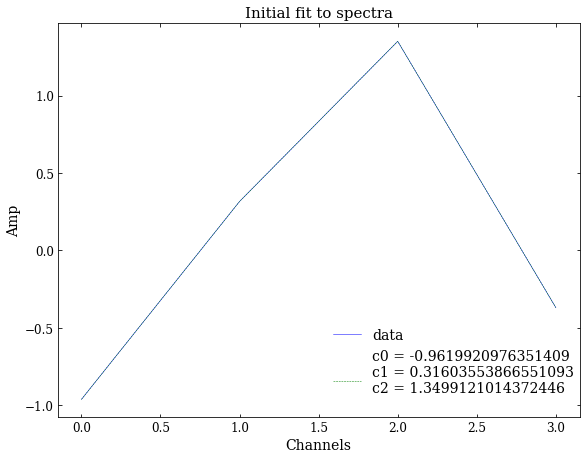

2022-05-31 21:39:47,346 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 2
2022-05-31 21:39:47,349 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [-0.9619920976351409, 0.31603553866551093, 1.3499121014372446, 2.2733815000484676e-08, 51.56359176153182, 8.292625456516848, 0.4722043825961695, 111]
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
2022-05-31 21:39:47,379 - run_fit -burstfit.curvefit - WARNING - Fit errors are not finite. Retrying with p0+-(0.2*p0) bounds
2022-05-31 21:39:47,401 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-31 21:39:47,404 - sgram_fit -burstfit.fit - INFO - c0: -0.9440649683740657 +- 85895734.48310544
2022-05-31 21:39:47,406 - sgram_fit -burstfit.fit - INFO - c1: 0.32194116037666987 +- 45620610.5008595
2022-05-31 21:39:47,408 - sgram_fit -burstfit.fit

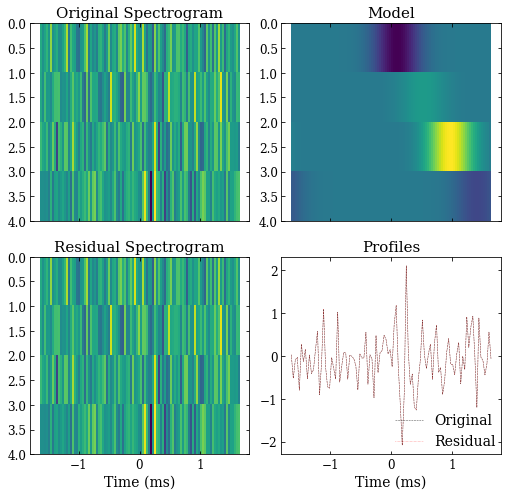

2022-05-31 21:39:47,828 - model -burstfit.fit - INFO - Making model.
2022-05-31 21:39:47,831 - model -burstfit.fit - INFO - Found 2 components.
2022-05-31 21:39:47,834 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-31 21:39:47,836 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-31 21:39:47,838 - model -burstfit.fit - INFO - Making model.
2022-05-31 21:39:47,840 - model -burstfit.fit - INFO - Found 2 components.
2022-05-31 21:39:47,844 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 0.11770550336485479
2022-05-31 21:39:47,845 - fitall -burstfit.fit - INFO - Fixed component exceeded. Terminated individual component fitting.
2022-05-31 21:39:47,847 - fitall -burstfit.fit - INFO - Final number of components 2 > 1. Fitting all components together.
2022-05-31 21:39:47,849 - fit_all_components -burstfit.fit - INFO - Fitting 2 components together.
2022

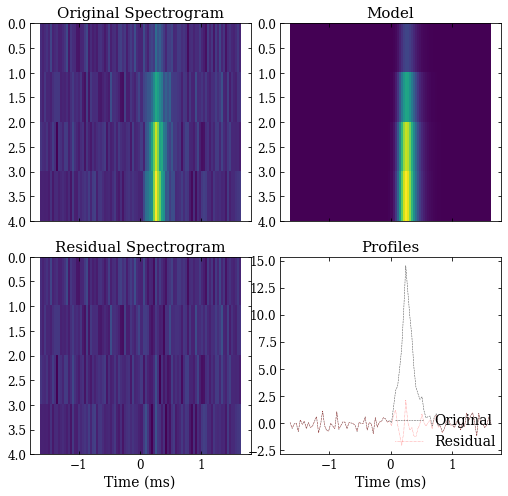

2022-05-31 21:39:48,608 - model -burstfit.fit - INFO - Making model.
2022-05-31 21:39:48,611 - model -burstfit.fit - INFO - Found 2 components.
2022-05-31 21:39:48,615 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-31 21:39:48,618 - get_off_pulse_region -burstfit.fit - INFO - Using sgram all-component-fit parameters.
2022-05-31 21:39:48,619 - model -burstfit.fit - INFO - Making model.
2022-05-31 21:39:48,621 - model -burstfit.fit - INFO - Found 2 components.
2022-05-31 21:39:48,625 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 0.11770318623635802
2022-05-31 21:39:48,626 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-31 21:39:48,628 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-31 21:39:48,633 - tests -root - INFO - P values: T-test (0.18051), Kruskal (0.14148), KS (0.28267), F-test (0.15210)
2022-05-31 21:

{bf}.calc_redchisq()= 0.11770318623635802


In [12]:
bf_S1T2_c2 = fit_paper_curvefit(data_burst, ['S', 'mu_t', 'sigma_t', 'tau'], pulse_fn, 
          [(0, 50, 0, 0),(np.inf, 60, 10*bd.width, np.inf)], 
          ['c0', 'c1', 'c2'], model_free_normalized_4, fix_ncomp = True, ncomp=2, plot=True)

2022-05-31 21:39:54,494 - set_initial_pos -root - INFO - Setting initial positions for MCMC.
2022-05-31 21:39:54,499 - set_initial_pos -burstfit.mcmc - INFO - Initial guess for MCMC is: [ 9.79927129e-02  2.77676521e-01  4.34523808e-01  3.04668641e+02
  5.57527858e+01  2.29519527e+00  2.62304040e+00  1.10745824e+02
 -9.44064968e-01  3.21941160e-01  1.37517234e+00  2.23104567e-08
  5.25920093e+01  8.39405378e+00  4.72204383e-01  1.33199998e+02]
2022-05-31 21:39:54,503 - set_priors -burstfit.mcmc - INFO - Setting priors for MCMC.
2022-05-31 21:39:54,506 - set_priors -burstfit.mcmc - INFO - Found tau in param_names. Setting its min value of prior to 0.
2022-05-31 21:39:54,508 - set_priors -burstfit.mcmc - INFO - Found sigma_t in param_names. Setting its min value of prior to 0.
2022-05-31 21:39:54,509 - set_priors -burstfit.mcmc - INFO - Found sigma_t and tau in param_names. Setting its max value of prior to 2*(max_tau_prior(4.721472715553272) + max_sigma_t_prior(15.109296812891413))
2022-

2022-05-31 21:43:20,639 - hist2d -root - WARNING - Too few points to create valid contours
2022-05-31 21:43:20,715 - hist2d -root - WARNING - Too few points to create valid contours
2022-05-31 21:43:20,792 - hist2d -root - WARNING - Too few points to create valid contours
2022-05-31 21:43:20,868 - hist2d -root - WARNING - Too few points to create valid contours
2022-05-31 21:43:20,946 - hist2d -root - WARNING - Too few points to create valid contours
2022-05-31 21:43:21,023 - hist2d -root - WARNING - Too few points to create valid contours
2022-05-31 21:43:59,917 - make_autocorr_plot -burstfit.mcmc - WARNING - Not enough valid autocorrelation values to plot. Not making autocorrelation plot.


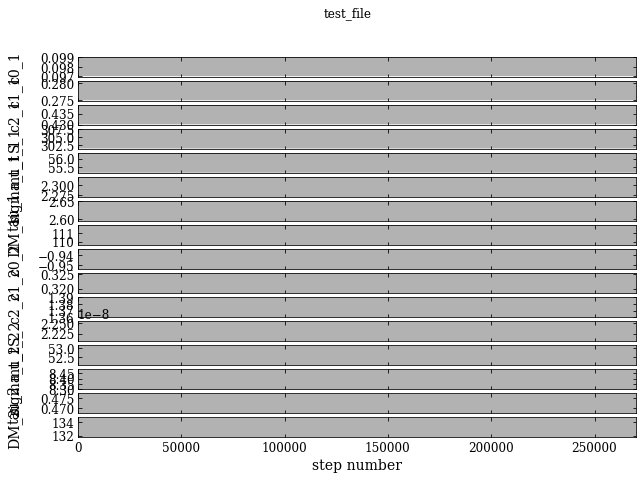

<Figure size 432x288 with 0 Axes>

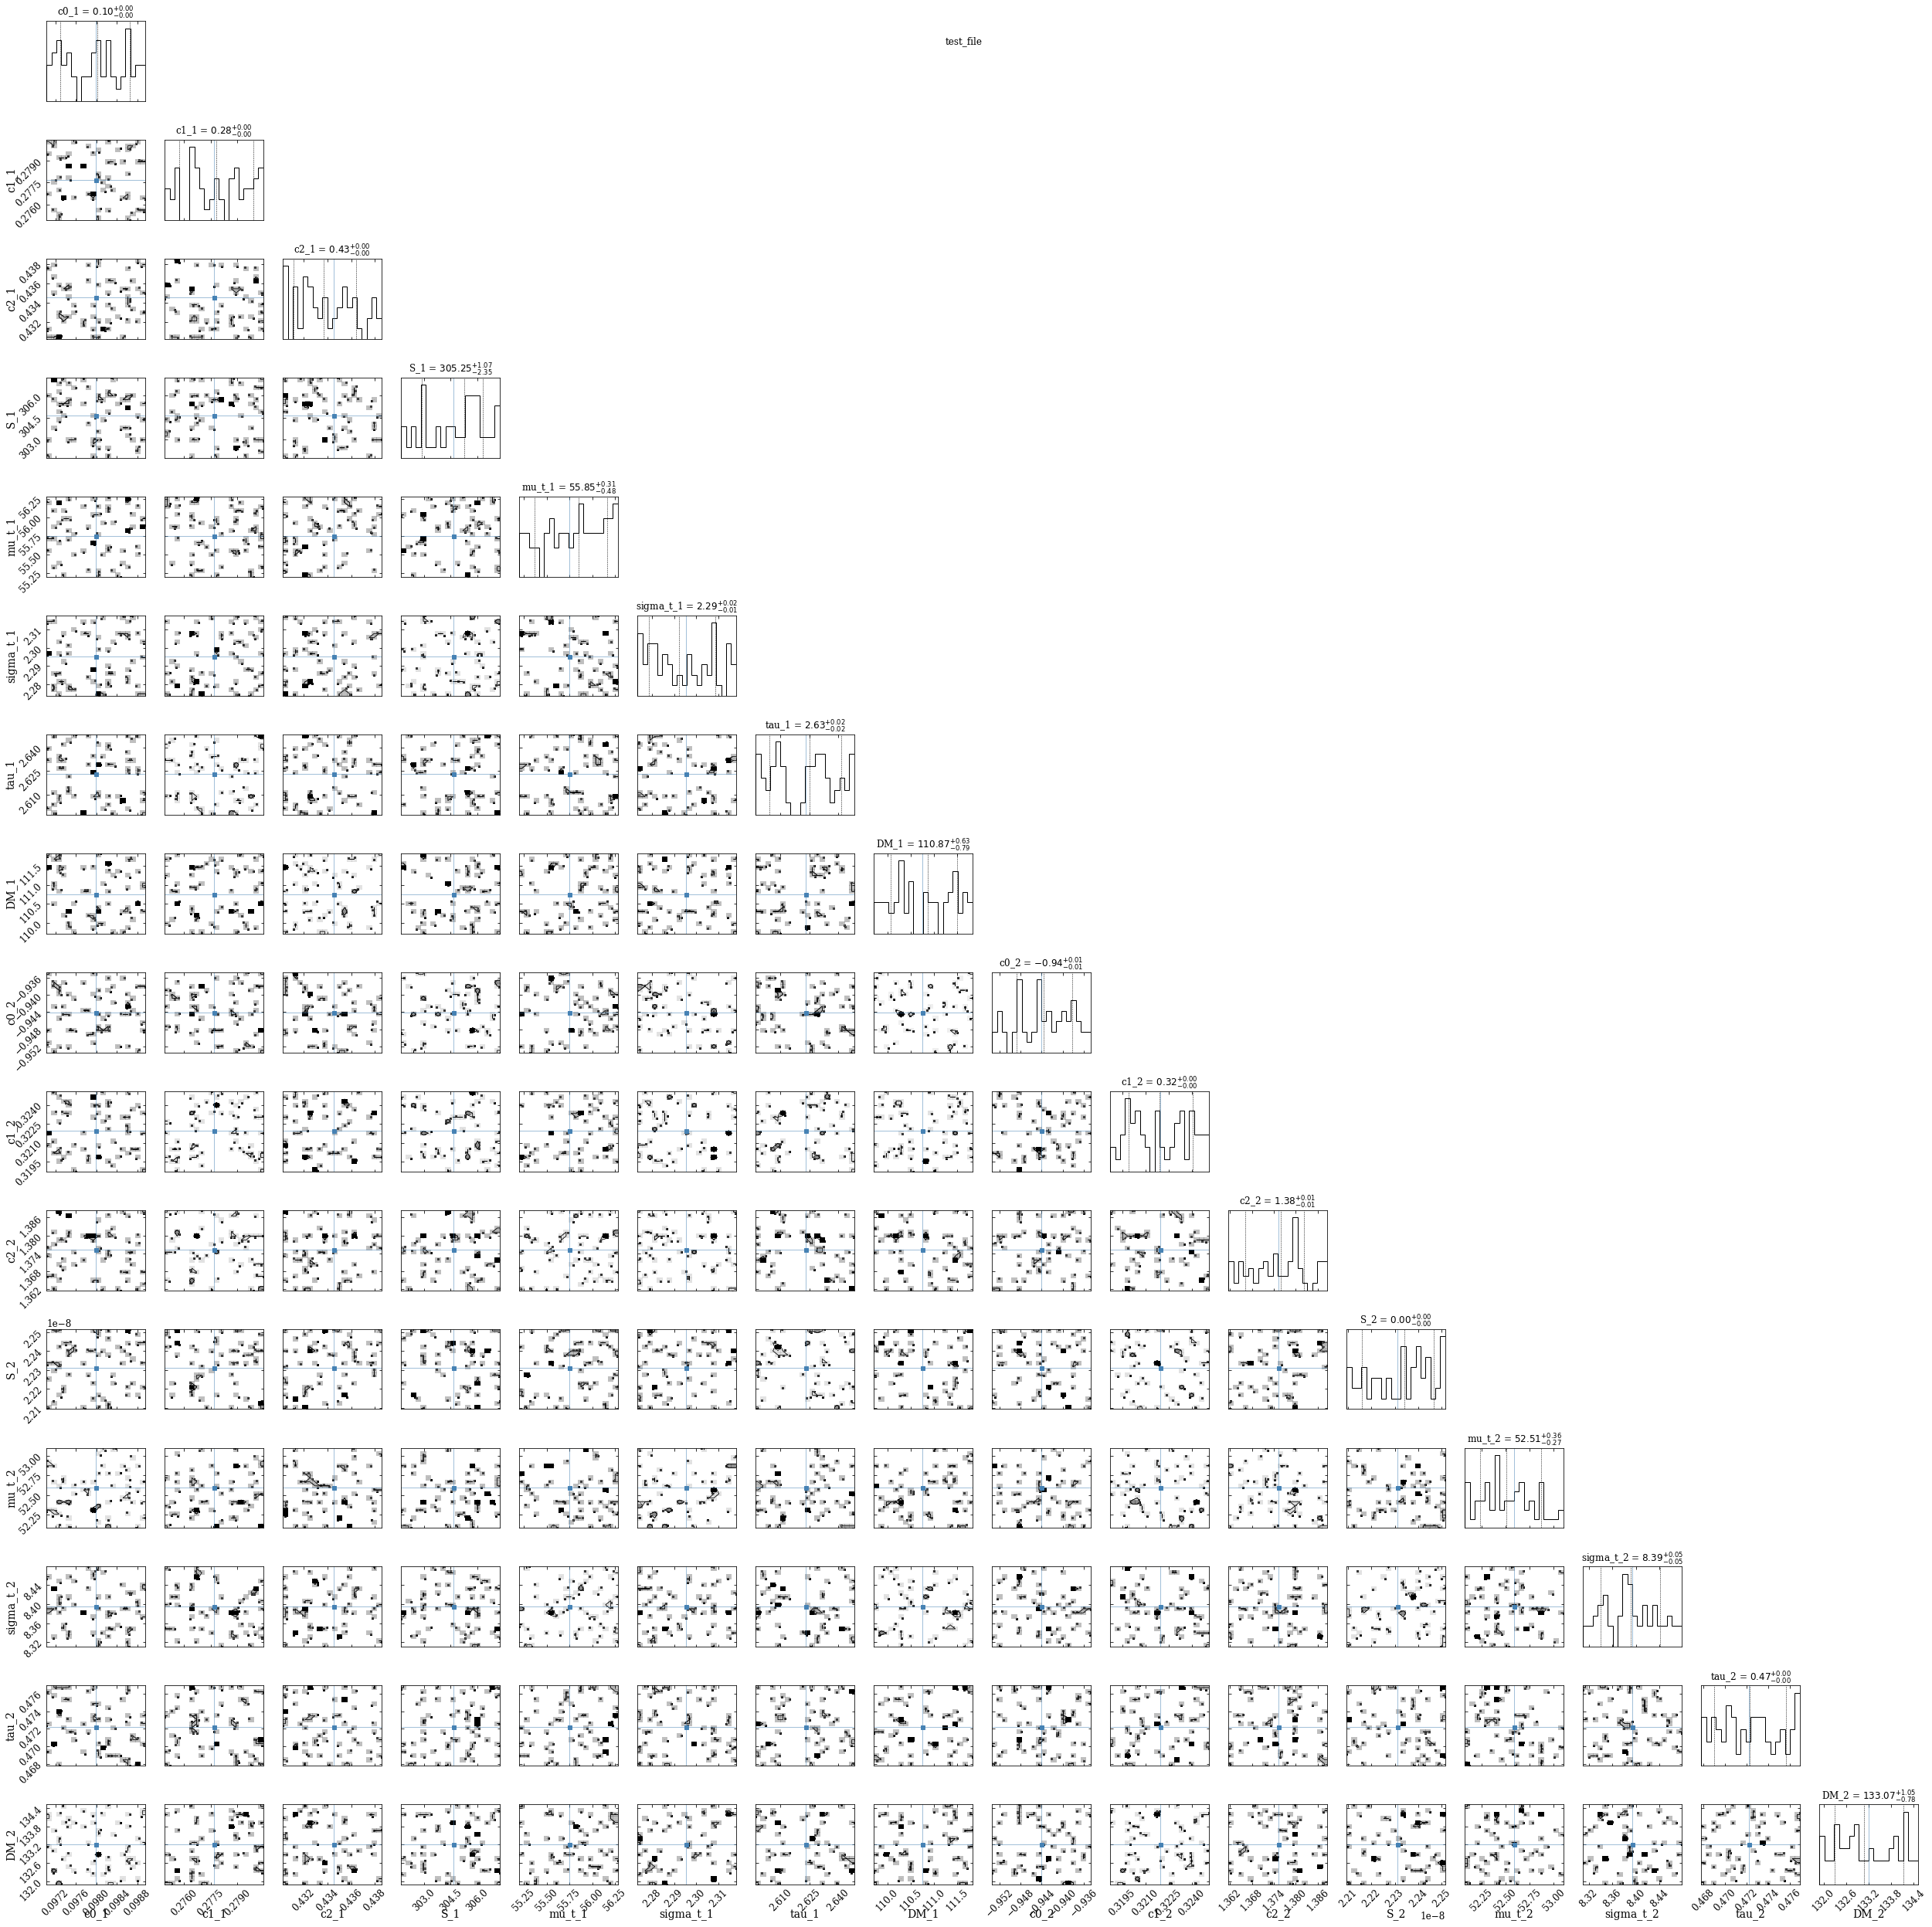

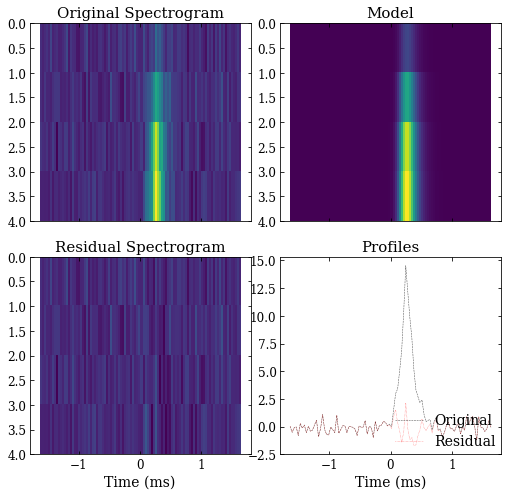

{bf}.bic =  143.52424896568004


0

In [13]:
fit_paper_mcmc_bic(bf_S1T2_c2, mcmc=True)

In [14]:
select_model(["bf_S1T1_c1", "bf_S1T2_c1", "bf_S1T2_c2"])


(['bf_S1T1_c1', 'bf_S1T2_c1', 'bf_S1T2_c2'],
 array([ 91.51716141,  95.59347085, 143.52424897]))

In [65]:
# save best model results in Latex table 
#bf_S1T1_c1.mcmc_params
#bf_S1T1_c1.param_names

print(bf_S1T1_c1.param_names)
# print(bf_S1T1_c1.mcmc_params[1]['popt'])
# print(bf_S1T1_c1.mcmc_params[1]['perr'])



for ncomp in range(bf_S1T1_c2.ncomponents):
    for i in range(len(bf_S1T1_c2.param_names)):
        print("${:.4}^{{+{:.2}}}_{{-{:.2}}}$".format(bf_S1T1_c2.mcmc_params[ncomp + 1]['popt'][i], bf_S1T1_c2.mcmc_params[ncomp + 1]['perr'][i][0], bf_S1T1_c2.mcmc_params[ncomp + 1]['perr'][i][1])) 
        
# '{:-9} YES votes  {:2.2%}'.format(yes_votes, percentage)
# import pandas as pd 
# table = pd.DataFrame(dict(name=['Raphael', 'Donatello'],
#                   mask=['red', 'purple'],
#                   weapon=['sai', 'bo staff']))

['c0', 'c1', 'c2', 'S', 'mu_t', 'sigma_t', 'DM']
$0.09247^{+0.00073}_{-0.00055}$
$0.2724^{+0.002}_{-0.0017}$
$0.4362^{+0.0028}_{-0.003}$
$282.7^{+2.1}_{-1.8}$
$58.04^{+0.32}_{-0.47}$
$3.126^{+0.024}_{-0.014}$
$110.7^{+0.91}_{-0.65}$
$0.5028^{+0.0032}_{-0.0031}$
$-0.8154^{+0.005}_{-0.0048}$
$0.605^{+0.0051}_{-0.0032}$
$-0.8537^{+0.0066}_{-0.0061}$
$53.74^{+0.25}_{-0.32}$
$2.605^{+0.017}_{-0.014}$
$108.9^{+0.94}_{-0.5}$


In [2]:
np.shape(data_burst)

NameError: name 'np' is not defined